In [1]:
!pip install kaggle

In [0]:
! cp /content/kaggle.json /root/.kaggle

In [5]:
import kaggle 

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d uciml/autompg-dataset

  0% 0.00/6.31k [00:00<?, ?B/s]
100% 6.31k/6.31k [00:00<00:00, 5.59MB/s]


In [8]:
if int(input())==1:
  !unzip /content/autompg-dataset.zip
else:
  pass

1
Archive:  /content/autompg-dataset.zip
  inflating: auto-mpg.csv            


# creating tensorflow pipelines for CSV files.

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [10]:
dataframe=pd.read_csv('/content/auto-mpg.csv',na_filter=True,na_values="?")
dataframe

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [11]:
dataframe.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

##checking if there is any missing values

In [12]:
dataframe.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [0]:
dataframe=dataframe.dropna()

For our regression problem we are going to consider only two continous value 

so we are going to take horsepower and mpg.


In [14]:
new_df=dataframe[['mpg','horsepower']]
new_df.head()

,mpg,horsepower
0,18.0,130.0
1,15.0,165.0
2,18.0,150.0
3,16.0,150.0
4,17.0,140.0


## Here we read dataset and we are going to convert that intop numpy arrays so that we can then convert it easily into tensors.


In [0]:
MPG=new_df[['mpg']].astype('float64').values
Horsepower=new_df[['horsepower']].astype('float64').values

In [16]:
type(MPG)

numpy.ndarray

# so here we are going to build the tensrflow pipelines using numpy arrays

In [0]:
mpgTensor=tf.data.Dataset.from_tensor_slices(MPG)
horsepowerTensor=tf.data.Dataset.from_tensor_slices(Horsepower)

In [18]:
mpgTensor.element_spec

TensorSpec(shape=(1,), dtype=tf.float64, name=None)

In [19]:
horsepowerTensor.element_spec

TensorSpec(shape=(1,), dtype=tf.float64, name=None)

In [20]:
combine_Dataset=tf.data.Dataset.zip((mpgTensor,horsepowerTensor))
combine_Dataset.element_spec

(TensorSpec(shape=(1,), dtype=tf.float64, name=None),
 TensorSpec(shape=(1,), dtype=tf.float64, name=None))

Inspecting the content of combine dataset using for loop.
You may use inter keyword to inspect the content .

In [21]:
for (i,j) in combine_Dataset.take(5):
  print(i.numpy(),j.numpy())

[18.] [130.]
[15.] [165.]
[18.] [150.]
[16.] [150.]
[17.] [140.]


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input,InputLayer

In [23]:
model=tf.keras.Sequential()
model.add(InputLayer(input_shape=(1,)))
model.add(Dense(10,use_bias=True,input_shape=[1]))
model.add(Dense(1,activation='linear'))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.90)

model.compile(optimizer=optimizer,
              loss='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


#we are going tyo use learning rate shedular call back so that we can find optimum learning rate through it 

In [0]:
callbacks=tf.keras.callbacks.LearningRateScheduler(
    lambda epochs: 1e-8 * 10**(epochs/20)
)

we use learning rate shedular for finding optimum learning rate i.e. the rate learning rate at which we get a minimum loss. 
so to findout that we use lerning rate shedular.

In [25]:
history=model.fit(combine_Dataset,epochs=100,callbacks=[callbacks])

Epoch 1/100
392/392 [==============================] - 1s 1ms/step - loss: 105.6795 - lr: 1.0000e-08
Epoch 2/100
392/392 [==============================] - 0s 1ms/step - loss: 105.5659 - lr: 1.1220e-08
Epoch 3/100
392/392 [==============================] - 0s 1ms/step - loss: 105.4384 - lr: 1.2589e-08
Epoch 4/100
392/392 [==============================] - 0s 1ms/step - loss: 105.2953 - lr: 1.4125e-08
Epoch 5/100
392/392 [==============================] - 0s 1ms/step - loss: 105.1348 - lr: 1.5849e-08
Epoch 6/100
392/392 [==============================] - 0s 1ms/step - loss: 104.9548 - lr: 1.7783e-08
Epoch 7/100
392/392 [==============================] - 0s 1ms/step - loss: 104.7526 - lr: 1.9953e-08
Epoch 8/100
392/392 [==============================] - 0s 1ms/step - loss: 104.5259 - lr: 2.2387e-08
Epoch 9/100
392/392 [==============================] - 0s 1ms/step - loss: 104.2715 - lr: 2.5119e-08
Epoch 10/100
392/392 [==============================] - 0s 1ms/step - loss: 103.9861 - lr: 

(1e-08, 0.0001, 0.0, 150.0)

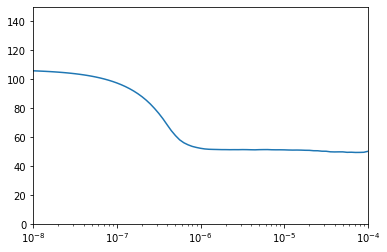

In [26]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8,1e-4,0,100])

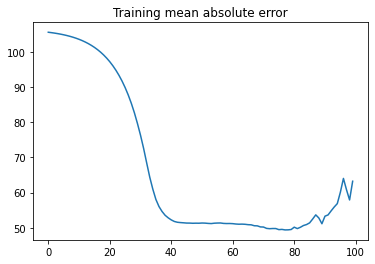

In [34]:
plt.plot(history.history['loss'])
plt.title('Training mean absolute error')
plt.show()

##we are going to choose learning rate from above semilog graph and remove learning rate shedular callback from the model.fit method.

In [27]:
model2=tf.keras.Sequential()
model2.add(InputLayer(input_shape=(1,)))
model2.add(Dense(64,use_bias=True,activation='relu',input_shape=[1]))
model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='linear'))

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5,momentum=0.90)

model2.compile(optimizer=optimizer,
              loss='mae',
               metrics=['mean_absolute_error']
               )

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [29]:
history2=model2.fit(combine_Dataset,epochs=500,verbose=2)

Epoch 1/500
392/392 - 1s - loss: 60.6801 - mean_absolute_error: 60.6801
Epoch 2/500
392/392 - 1s - loss: 49.6431 - mean_absolute_error: 49.6431
Epoch 3/500
392/392 - 1s - loss: 49.7570 - mean_absolute_error: 49.7570
Epoch 4/500
392/392 - 1s - loss: 49.8244 - mean_absolute_error: 49.8244
Epoch 5/500
392/392 - 1s - loss: 49.9281 - mean_absolute_error: 49.9281
Epoch 6/500
392/392 - 1s - loss: 49.8588 - mean_absolute_error: 49.8588
Epoch 7/500
392/392 - 1s - loss: 49.8021 - mean_absolute_error: 49.8021
Epoch 8/500
392/392 - 1s - loss: 49.8273 - mean_absolute_error: 49.8273
Epoch 9/500
392/392 - 1s - loss: 49.7725 - mean_absolute_error: 49.7725
Epoch 10/500
392/392 - 1s - loss: 49.7231 - mean_absolute_error: 49.7231
Epoch 11/500
392/392 - 1s - loss: 49.6781 - mean_absolute_error: 49.6781
Epoch 12/500
392/392 - 1s - loss: 49.6371 - mean_absolute_error: 49.6371
Epoch 13/500
392/392 - 1s - loss: 49.5438 - mean_absolute_error: 49.5438
Epoch 14/500
392/392 - 1s - loss: 49.3422 - mean_absolute_er

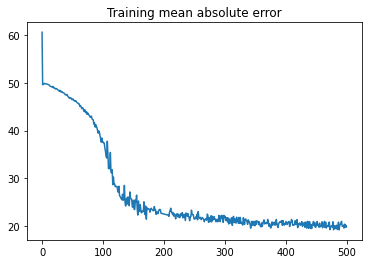

In [35]:
plt.plot(history2.history['loss'])
plt.title('Training mean absolute error')
plt.show()

we can clearly see that there are some fluctuvations in endiing we can zoom taht with following command

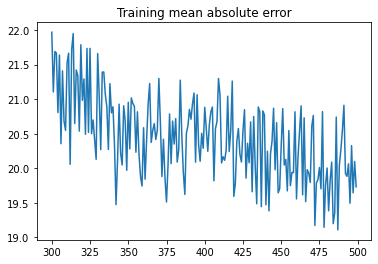

In [38]:
epochs=range(len(history2.history['loss']))
plt.plot(epochs[300:],history2.history['loss'][300:])
plt.title('Training mean absolute error')
plt.show()

Conclusion form this fig:
we can stop our training after almost 400 epoch it clearly shows that our model is still learning but after you tain further it not going to improve accuracy in large amount. Thats why we should stop training so that our costliest element i.e. Time can be saved.
